# 1. Исследовательский анализ данных

Found 7591 validated image filenames.
(7591, 2)


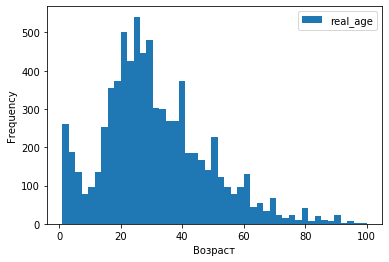

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        #колонки в датасете labels
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        #целевой признак будет в виде one-hot vector
        class_mode='raw',
        seed=12345)

print(labels.shape)
labels.plot.hist(bins='fd')
plt.xlabel('Возраст')
plt.show()

<div class="alert alert-block alert-warning">
Пик наблюдается при около 25. Также небольшой скачок значений близко к нулю. Следовательно больше всего у нас примеров молодежи и детей до 10 лет.
</div>

In [2]:
print(labels.info())
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Пропусков нет.

<div class="alert alert-block alert-info">
<b>Совет: </b> Не забывай про методы первичного анализа (head и info), которые нужно использовать после загрузки файла.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Количество столбиков на диаграмме можно было увеличить.
</div>

In [3]:
features, targets = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

In [4]:
targets.shape

(32,)

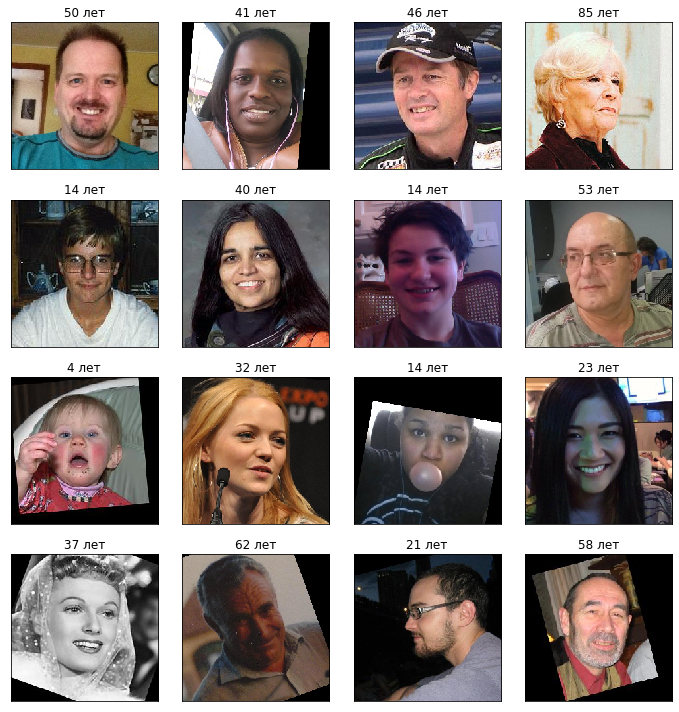

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(str(targets[i]) + ' лет')
    plt.tight_layout()

<div class="alert alert-block alert-warning">
Большинство изображений цветные размером (224 на 224). Для некоторых проведена аугментация в виде поворота.
</div>

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

<div class="alert alert-block alert-success">
<b>Успех:</b> Модель определена корректно. Молодец, что использовал аугментацию только на тренировочной чатси данных.
</div>

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 49s - loss: 211.5107 - mae: 11.0054 - val_loss: 1158.0676 - val_mae: 29.6162
Epoch 2/20
356/356 - 40s - loss: 140.0641 - mae: 9.0812 - val_loss: 278.1700 - val_mae: 13.1571
Epoch 3/20
356/356 - 40s - loss: 110.7297 - mae: 8.0508 - val_loss: 148.2156 - val_mae: 9.4864
Epoch 4/20
356/356 - 40s - loss: 95.4181 - mae: 7.4833 - val_loss: 108.2798 - val_mae: 7.9812
Epoch 5/20
356/356 - 40s - loss: 79.8278 - mae: 6.8291 - val_loss: 178.0613 - val_mae: 9.7676
Epoch 6/20
356/356 - 40s - loss: 66.8851 - mae: 6.2426 - val_loss: 170.2795 - val_mae: 10.5151
Epoch 7/20
356/356 - 40s - loss: 55.9369 - mae: 5.7523 - val_loss: 89.2837 - val_mae: 7.1589
Epoch 8/20
356/356 - 40s - loss: 52.9695 - mae: 5.5910 - val_loss: 131.7785 - val_mae: 8.7111
Epoch 9/20
356/356 - 40s - loss: 43.0853 - mae: 5.0047 - val_loss: 114.9671 - val_mae: 8.3337
Epoch 10/20
356/356 - 40s - loss: 38.5972 - mae: 4.7666 - val_loss: 128.7263 - val_mae: 8.6770
Epoch 11/20
356/356 - 40s - loss: 35.3977 - mae: 4.5312 - val_loss: 117.5225 - val_mae: 8.4846
Epoch 12/20
356/356 - 40s - loss: 30.1077 - mae: 4.2149 - val_loss: 109.7401 - val_mae: 7.7020
Epoch 13/20
356/356 - 40s - loss: 25.5061 - mae: 3.9038 - val_loss: 93.7540 - val_mae: 7.4362
Epoch 14/20
356/356 - 40s - loss: 25.3285 - mae: 3.8761 - val_loss: 123.0311 - val_mae: 8.7339
Epoch 15/20
356/356 - 40s - loss: 22.8995 - mae: 3.6733 - val_loss: 104.2647 - val_mae: 7.9555
Epoch 16/20
356/356 - 40s - loss: 21.6313 - mae: 3.5727 - val_loss: 89.5751 - val_mae: 7.2702
Epoch 17/20
356/356 - 41s - loss: 20.4163 - mae: 3.4889 - val_loss: 102.4059 - val_mae: 7.7958
Epoch 18/20
356/356 - 40s - loss: 17.8541 - mae: 3.2719 - val_loss: 86.0335 - val_mae: 7.0617
Epoch 19/20
356/356 - 40s - loss: 16.7227 - mae: 3.1519 - val_loss: 135.7328 - val_mae: 9.2148
Epoch 20/20
356/356 - 40s - loss: 22.0031 - mae: 3.6247 - val_loss: 86.4294 - val_mae: 7.0164
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 86.4294 - mae: 7.0164
Test MAE: 7.0164

```

# 3. Анализ обученной модели

Сначала создаем две функции для загрузки данных, каждая из которых использует ImageDataGenerator для динамической загрузки изображений батчами размером 32. Признаки загружаем из отдельного датасета. 

Модель создаем на основе ResNet50, предобученной на датасете imagenet. Указываем входной размер изображения, который (224,224). Все изображения будут подводиться к этому размеру. В нашу модель не включаем верхние полносвязные слои, которые в последствии будут адаптированы под нашу задачу. Дальше усредняем всю информацию в нашем изображении через GlobalAveragePooling2D, что дает нам один пиксель с 512 каналами (для ResNet50). И в конце добавляем выходной слой с единственным нейроном. 

После 20 эпох модель показывает значение метрики MAE 7.0164.